In [13]:
from pandas import get_dummies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple

<h1>Functions</h1>

In [14]:
def normalize_and_get_dummies(data: pd.DataFrame) -> pd.DataFrame:
    """Normalizes year and odometer and encodes categorical variables into dummy variables"""
    
    data = get_dummies(data)

    #Normalizing the numerical variables
    data['year'] = (data['year'] - 2001)
    data['odometer'] = (data['odometer'] - data['odometer'].min()) / (data['odometer'].max() - data['odometer'].min())
    
    return data

In [15]:
def remove_categories(data: pd.DataFrame) -> pd.DataFrame:
    """Removes categories according to EDA"""
    #Creating the size_type feature
    data['size_type'] = data['size']+"-"+data['type']

    #Dropping size, cylinders, type, fuel and transmission, after EDA
    data.drop(columns=['size', 'cylinders', 'type', 'fuel', 'transmission'], inplace=True)

    return data

In [16]:
def add_year_squared(data: pd.DataFrame) -> pd.DataFrame:
    """Adds one column of the value of the year squared"""
    
    data.insert(2, 'year_squared',data['year']**2)
    
    return data

In [17]:
def transformations(data: pd.DataFrame, are_cat_removed:bool, is_year_squared: bool) -> pd.DataFrame:
    """Pipeline with remove_categories, normalizing, getting dummies transformations
    if add_year_squared is true, adds a collumn with the year squared"""

    if(are_cat_removed == True):    
        data = remove_categories(data)

    if(is_year_squared == True):
        data = add_year_squared(data)

    data = normalize_and_get_dummies(data)
    
    return data

In [19]:
def get_arrays(data: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    """ Recieves the clean data frame and returns matrix X and array d, according to the course's definitions"""

     # Column vector with prices
    d = data['price']

    # Data matrix (all features except prices)
    data.drop('price', axis=1, inplace=True)
    X = data

    return X.to_numpy(), d.to_numpy()

In [20]:
def regression(X: np.ndarray, d: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # Method showed in class
    R = X.T @ X
    p = X.T @ d
    wo = np.linalg.solve(R,p)
    fitting_error = d - X @ wo

    return wo, fitting_error

In [21]:
are_cat_removed_vals = [True, False]
is_year_squared_vals = [True, False]
mse = [0, 0, 0, 0]

In [22]:
v_clean_train = pd.read_csv("./vehicles_cleaned_train.csv")    
v_clean_test = pd.read_csv("./vehicles_cleaned_test.csv")

In [23]:
i = 0
for are_cat_removed_val in are_cat_removed_vals:
    for is_year_squared_val in is_year_squared_vals:
        print(f"---- remove_categories: {are_cat_removed_val}, add_year_squared: {is_year_squared_val} ----")
        # Fitting the linear model
        v_clean_train = pd.read_csv("./vehicles_cleaned_train.csv")    
        v_clean_test = pd.read_csv("./vehicles_cleaned_test.csv")
        train_data = v_clean_train
        train_data_transf = transformations(data=train_data, are_cat_removed=are_cat_removed_val, is_year_squared=is_year_squared_val)
        X_train, d_train = get_arrays(data=train_data_transf)
        wo, fitting_error = regression(X=X_train, d=d_train)
        print(f"Fitting MSE error: {np.mean(fitting_error**2)}")
        print(f"Fitting RMSE error: {np.sqrt(np.mean(fitting_error**2))}")

        #Evaluating the linear model
        test_data = v_clean_test
        test_data_transf = transformations(data=test_data, are_cat_removed=are_cat_removed_val, is_year_squared=is_year_squared_val)
        X_test, d_test = get_arrays(data=test_data_transf)
        prices_prediction = X_test @ wo
        print(f"Evaluating MSE error: {np.mean((prices_prediction - d_test)**2)}")
        print(f"Evaluating RMSE error: {np.sqrt(np.mean((prices_prediction - d_test)**2))}")
        mse[i] = np.mean((prices_prediction - d_test)**2)
        i += 1

---- remove_categories: True, add_year_squared: True ----
Fitting MSE error: 28678962.344645835
Fitting RMSE error: 5355.27425484875
Evaluating MSE error: 27365926.43329515
Evaluating RMSE error: 5231.245208675956
---- remove_categories: True, add_year_squared: False ----
Fitting MSE error: 28960469.86187793
Fitting RMSE error: 5381.493274350339
Evaluating MSE error: 27599592.4528602
Evaluating RMSE error: 5253.531426846155
---- remove_categories: False, add_year_squared: True ----
Fitting MSE error: 27218338.30753545
Fitting RMSE error: 5217.119732911585
Evaluating MSE error: 25588037.897443153
Evaluating RMSE error: 5058.46200909359
---- remove_categories: False, add_year_squared: False ----
Fitting MSE error: 27519261.919665784
Fitting RMSE error: 5245.880471347568
Evaluating MSE error: 25857605.28760358
Evaluating RMSE error: 5085.037392940545


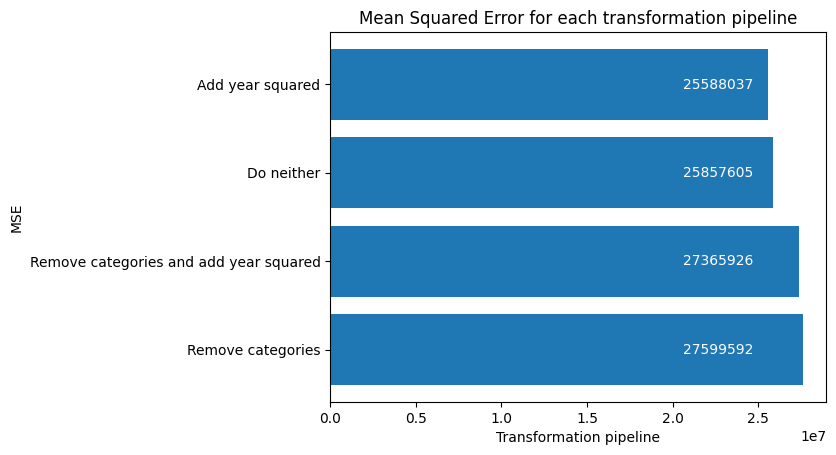

In [53]:
error_legend = ['Remove categories and add year squared',
                'Remove categories',
                'Add year squared',
                'Do neither'
                ]
sorted_error = sorted(zip(mse, error_legend), reverse=True)
sorted_mse, sorted_legend = zip(*sorted_error)
plt.barh(sorted_legend, sorted_mse)

plt.text(sorted_mse[0]-0.7e7, 'Add year squared', str(int(sorted_mse[3])), va='center', color='white')
plt.text(sorted_mse[0]-0.7e7, 'Do neither', str(int(sorted_mse[2])), va='center', color='white')
plt.text(sorted_mse[0]-0.7e7, 'Remove categories and add year squared', str(int(sorted_mse[1])), va='center', color='white')
plt.text(sorted_mse[0]-0.7e7, 'Remove categories', str(int(sorted_mse[0])), va='center', color='white')

plt.title('Mean Squared Error for each transformation pipeline')
plt.xlabel('Transformation pipeline')
plt.ylabel('MSE')
plt.show()